<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/observability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 447: Observability


Updated by 
 Dr. Chris Takahashi

Authored by Prof. Eric Klavins &copy; 2019, University of Washington


# Code

In [6]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation

# Uncomment on Google colab
# !pip install JSAnimation
!pip install control

#from JSAnimation.IPython_display import display_animation
from control import * 

%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

     |████████████████████████████████| 256kB 2.7MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=f3315755efaa5d523284e5efa3524c4bf6ef96cf50117658eb537a3fcec82c2d
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


# Definitions

$\newcommand{\x}{x}$

One of the problems with full state feedback is that it assumes we have access to the state of the system, but really we only have access to the outputs. What an **observer** does is take the input and output to the plant and try to estimate what $\x$ is.

<img width=75% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/observer-problem.png">

The idea with an observer is that it **simulates** the system, not knowing the exact parameters or the initial condition. For example, a *poor* observer could be:

\begin{align}
\dot{\hat{\x}} & = A \hat{\x} + B u \\
\hat{y} & = C \hat{\x}
\end{align}

where $\hat{\x}$ is a new vector, called the estimate, with the same dimension as $\x$. Also, $\hat{y}$ is the estimated output given the estimated state.

To evaluate the above observer, we can look at the error between the state and its estimate, and the output and its estimate:

$$
{\bf e} = \x - \hat{\x} 
$$

and

$$
y - \hat y.
$$

Since both the state and the estimate evolve according to the same matrices, we have

\begin{align}
\dot x - \dot {\hat x} & = A (x - \hat x) \\
{y} - \hat y & = C({\x} - \hat\x)
\end{align}

If $A$ is stable, then the estimate $\hat{\x}$ converges to $\x$. That seems good, but there are issues:

- $\hat{\x}$ converges to $\x$ at the same rate that $\x$ converges to its equilibrium (since the $A$ matrix is the same). You might want the estimate a lot earlier.
- If $A$ is only an approximation, then $\hat{\x}$ and $\x$ may actually evolve quite differently.
- It requires $A$ to be stable. But you might be controlling an unstable plant.

Example System
---
As a running example, we define a system below. We suppose there is a true $A$ matrix and an approximate $A$ matrix that comes from the modeling department. Alternatively, we could also imagine an exact $A$ matrix, but that it comes from linearizing a nonlinear system that provides the actual dynamics (we'll do that later with the levitation example).

In [0]:
# Example: A bad observer

# Actual A Matrix
A = Matrix([
    [0,-1.0,0],
    [3,0,-72.33],
    [0,0.5,-30.0]])

# Appoximated A matrix
Approx = Matrix([
    [0,-1.5,0],
    [3.1,0,-72.33],
    [0,0.5,-32.0]])

B = Matrix([
    [0],
    [0],
    [1]
])

C = Matrix([[1,0,0]])

Simulation of a poor observer
---

To evaluate the example observer above, we apply it to the above system in simulation and plot the states and the state estimates. You can see that the estimates approximately track the actual states, but that they (a) do not always settle in the right places and (b) they they don't settle very quickly.

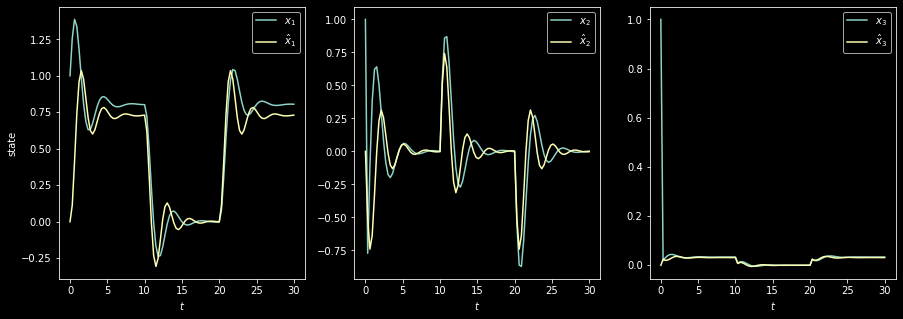

In [24]:
def input(t):
    if t < 10:
        return 1
    elif t < 20:
        return 0
    else:
        return 1
    
def f(X,t):
    x = X[:3]
    xhat = X[3:6]
    u = input(t)
    return flatten(
        (A*Matrix(x) + B*u).tolist() + 
        (Approx*Matrix(xhat) + B*u).tolist())

t=np.linspace(0,30,100)
X = spi.odeint(f,[1,1,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()
    
ax[0].set_ylabel("state");
    

# Luenberger Observer Design

$\newcommand{\x}{x}$

A much better design for an observer does the following:

\begin{align}
\dot{\hat{\x}} & = A \hat{\x} + B u + L(y - \hat{y}) \\
\hat{y} & = C \hat{\x}
\end{align}

where $L$ is a matrix of gains. To see how to design $L$, we look at the error dynamics for ${\bf e} = \x - \hat{\x}$:

\begin{align}
\dot{\bf e} & = A \x - A \hat{\x} - L({y}-\hat y) \\
 & = A {\bf e} - L C \x  + L C \hat{\x} \\
 & = (A-LC) {\bf e} .
\end{align}

This looks a lot like full state feedback. In fact, we may be able to place the poles of $A-LC$ anywhere via a suitably designed $L$. 

| OBSERVER DESIGN | CONTROLLER DESIGN |
|:---|:---|
|$A-LC$|$A-BK$|
|$L$ is $n \times 1$|$K$ is $1 \times n$|
|The system may not be *observable*|The system may not be *controllable*|
|Want to place the poles to be faster than poles of $A$|Want to place the poles for performance|

$\newcommand{\x}{x}$

Example
---

Let's design a matrix of gains $L$ to track the $\x$ for the above example. Let's decide we want the poles to be about 4 times the poles of $A$, and also to have no imaginary component (so there is no overshoot in the observer error). 

We can use the `place` command from the control toolbox, but we have to figure out how to transform $A$ and $C$ into the appropriate form. `place` takes matrices of the form $A$ and $B$ and places the poles of $A-BK$. If we transpose $A-LC$ to get

$$
(A-LC)^T = A^T - C^T L^T
$$

then we matrices of the right dimension for `place`.

In [25]:
An = np.array(Approx.transpose()).astype(np.float64)
Cn = np.array(C.transpose()).astype(np.float64)

desired_poles = 4*np.linalg.eig(An)[0]
desired_poles = np.array([ -10, -12, -14 ])
desired_poles

array([-10, -12, -14])

In [26]:
L = Matrix(place(An,Cn,desired_poles)).transpose()
L

⎡3.99999999999961 ⎤
⎢                 ⎥
⎢-172.790000000002⎥
⎢                 ⎥
⎣-63.6654223696955⎦

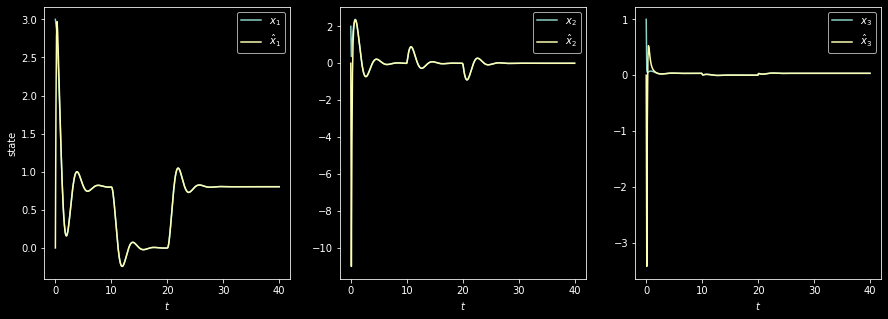

In [27]:
def f(X,t):
    x = Matrix([X[:3]]).transpose()
    xhat = Matrix([X[3:6]]).transpose()
    u = input(t)
    fb = L * ( C*x - C*xhat )
    return flatten(
        (A*x + B*u).tolist() + 
        (A*xhat + B*u + fb).tolist())

t=np.linspace(0,40,400)
X = spi.odeint(f,[3,2,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()
    
ax[0].set_ylabel("state");
# ax[0].set_ylim(-0.5,1.5)
# ax[1].set_ylim(-2,2)
# ax[2].set_ylim(-0.2,0.2)

# Observability

$\newcommand{\x}{x}$

**Def:** A system is **observable** if the initial state $\x(0)$ can be determined by watching $u(t)$ and $y(t)$ for a finite time. 

**Theorem:** A linear system is *observable* if and only if the poles of $A-LC$ can be place arbitrarily by choosing $L$.

**Theorem:** The system 

\begin{align}
\dot{\x} & = A \x + B u \\
y & = C \x
\end{align}

is observable if and only if 

$$
\mathcal{O} = \begin{pmatrix}
C \\
CA \\
C A^2 \\
\vdots \\
C A^{n-1}
\end{pmatrix}
$$

has full rank.

Note the similarity with the controllability matrix. In fact, we also have the following result:

**Theorem:** $A, C$ is observable if and only if $A^T, C^T$ is controllable. 

We used this above when we called `place` to design the $L$ matrix in the previous example. 

Example
---

Using the definition of $A$ from the above example we have:

In [28]:
O = Matrix([C,C*A,C*A**2])
O, O.rank()

⎛⎡ 1     0      0  ⎤   ⎞
⎜⎢                 ⎥   ⎟
⎜⎢ 0    -1.0    0  ⎥, 3⎟
⎜⎢                 ⎥   ⎟
⎝⎣-3.0   0    72.33⎦   ⎠

In [29]:
[C,C*A,C*A**2]

[[1  0  0], [0  -1.0  0], [-3.0  0  72.33]]

$\newcommand{\x}{x}$

Example
---
The following system is controllable, but not observable. You can see that there is on way to get any information about the second state from $y$.

\begin{align}
\dot{\x} & = \begin{pmatrix}
0 & 1 \\
0 & 0 
\end{pmatrix}\x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u \\
y & = ( 0 \;\; 1 ) \; \x
\end{align}


In [30]:
A = Matrix([
    [0,1],
    [0,0]
]);
B = Matrix([
    [0],
    [1]
])
C = Matrix([[0,1]])
O = Matrix([C,C*A])
O, O.rank()

⎛⎡0  1⎤   ⎞
⎜⎢    ⎥, 1⎟
⎝⎣0  0⎦   ⎠